Market Risk Modelling: VaR, CVaR and Volatility

This project builds and evaluates daily market risk models for an equally weighted portfolio of five large-cap US tech stocks (AAPL, MSFT, GOOG, NVDA, AMZN) using 2010–2019 data.   

Goals:
- Model portfolio volatility using rolling 21-day volatility, EWMA and GARCH(1,1) with Student-t innovations.  
- Estimated one-day VaR and CVaR via historical, parametric (Normal & Student-t) and Monte Carlo approaches, including time-varying VaR based on EWMA and GARCH volatility.  
- Evaluated model performance with exception counting and standard backtests (Kupiec and Christoffersen) and complemented this with historical stress testing over the GFC, Eurozone crisis and COVID-19 crash using stressed VaR/CVaR.


---

In [43]:
# 0. Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import norm, t

import yfinance as yf
import seaborn as sns
import statsmodels.api as sm
from arch import arch_model

plt.style.use("default")
sns.set_style("whitegrid")

In [44]:
# 1. Data: prices and portfolio returns

tickers = ['AAPL', 'MSFT', 'GOOG', 'NVDA', 'AMZN']
start_date = '2010-01-01'
end_date   = '2019-12-01'

data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)
prices = data["Close"].dropna()  # adjusted closes
print("Prices shape:", prices.shape)
display(prices.tail())

# Daily simple returns
asset_returns = prices.pct_change().dropna()
print("Asset returns shape:", asset_returns.shape)
display(asset_returns.head())

# Equal-weight portfolio
weights = np.array([1/len(tickers)] * len(tickers))
portfolio_returns = asset_returns.dot(weights)
portfolio_returns = pd.Series(portfolio_returns,
                              index=asset_returns.index,
                              name="Portfolio")
print("Portfolio returns shape:", portfolio_returns.shape)
portfolio_returns.head()


[*********************100%***********************]  5 of 5 completed

Prices shape: (2495, 5)


Ticker,AAPL,AMZN,GOOG,MSFT,NVDA
Date,,,,,
2019-11-22,63.162102,87.286003,64.326790,142.032928,5.245226
2019-11-25,64.269592,88.692001,64.890442,143.590073,5.501903
2019-11-26,63.767738,89.847000,65.231102,144.349655,5.397193
2019-11-27,64.624252,90.925499,65.203293,144.625015,5.432039
2019-11-29,64.481911,90.040001,64.804535,143.732483,5.394704


Asset returns shape: (2494, 5)


Ticker,AAPL,AMZN,GOOG,MSFT,NVDA
Date,,,,,
2010-01-05,0.001729,0.005900,-0.004404,0.000323,0.014603
2010-01-06,-0.015906,-0.018116,-0.025209,-0.006137,0.006397
2010-01-07,-0.001848,-0.017013,-0.023280,-0.010400,-0.019597
2010-01-08,0.006648,0.027077,0.013331,0.006896,0.002161
2010-01-11,-0.008821,-0.024041,-0.001512,-0.012720,-0.014016


Portfolio returns shape: (2494,)


Date
2010-01-05    0.003630
2010-01-06   -0.011794
2010-01-07   -0.014428
2010-01-08    0.011223
2010-01-11   -0.012222
Name: Portfolio, dtype: float64

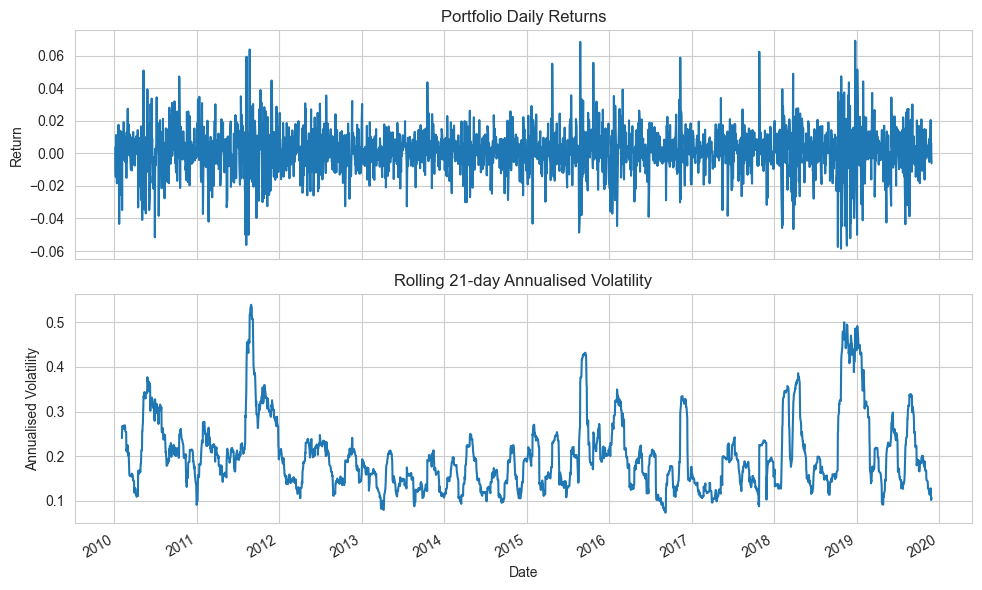

In [45]:
# 2. Historical volatility (rolling window)

window = 21  # 21 trading days ~ 1 month

daily_vol_21 = portfolio_returns.rolling(window).std()
ann_vol_21   = daily_vol_21 * np.sqrt(252)

fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

portfolio_returns.plot(ax=ax[0])
ax[0].set_title("Portfolio Daily Returns")
ax[0].set_ylabel("Return")

ann_vol_21.plot(ax=ax[1])
ax[1].set_title(f"Rolling {window}-day Annualised Volatility")
ax[1].set_ylabel("Annualised Volatility")

plt.tight_layout()
plt.show()


The 21-day rolling volatility confirms clear volatility clustering: long stretches of low volatility punctuated by short spikes. This justifies the use of conditional volatility models (EWMA, GARCH) rather than a single constant volatility estimate.

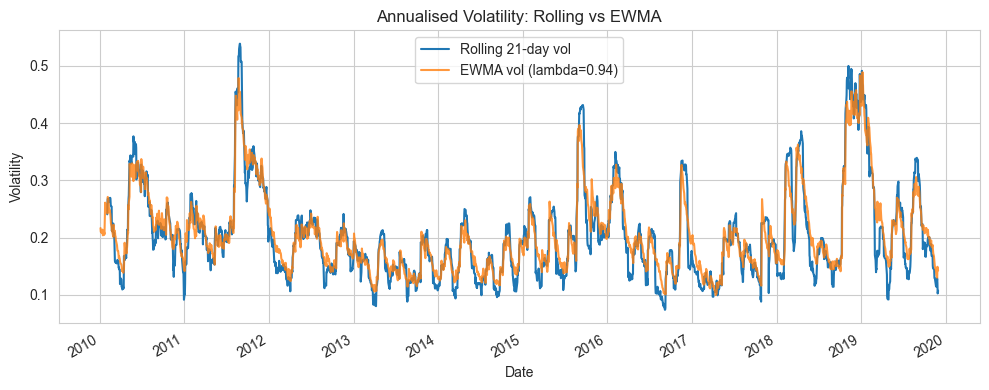

In [46]:
# 3. EWMA volatility

def ewma_volatility(returns, lam=0.94):
    """
    Compute EWMA volatility for a 1D return series.
    """
    returns = pd.to_numeric(returns, errors="coerce").dropna()
    ewma_var = np.zeros_like(returns.values)
    
    # initialise with unconditional variance
    ewma_var[0] = returns.var()
    
    for t in range(1, len(returns)):
        ewma_var[t] = lam * ewma_var[t-1] + (1 - lam) * returns.iloc[t-1]**2
    
    ewma_vol = np.sqrt(ewma_var)
    return lam, pd.Series(ewma_vol, index=returns.index, name="EWMA_vol")

lam, ewma_daily_vol = ewma_volatility(portfolio_returns)
ewma_ann_vol = ewma_daily_vol * np.sqrt(252)

fig, ax = plt.subplots(figsize=(10, 4))
ann_vol_21.plot(ax=ax, label=f"Rolling {window}-day vol")
ewma_ann_vol.plot(ax=ax, label=f"EWMA vol (lambda={lam})", alpha=0.8)
ax.set_title("Annualised Volatility: Rolling vs EWMA")
ax.set_ylabel("Volatility")
ax.legend()
plt.tight_layout()
plt.show()


 EWMA volatility reacts more quickly to large moves than the simple rolling standard deviation, while still smoothing out day-to-day noise. This makes EWMA a useful bridge between purely historical volatility and more structural time-series models like GARCH.


In [47]:
# 4. GARCH(1,1) volatility with Student-t innovations

# Scale to percent for arch package
am = arch_model(portfolio_returns * 100,
                vol='GARCH', p=1, q=1,
                dist='t', mean='Zero')  # or 'Constant'

res = am.fit(update_freq=10, disp='off')
print(res.summary())



                          Zero Mean - GARCH Model Results                           
Dep. Variable:                    Portfolio   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -4070.71
Distribution:      Standardized Student's t   AIC:                           8149.41
Method:                  Maximum Likelihood   BIC:                           8172.70
                                              No. Observations:                 2494
Date:                      Sat, Nov 29 2025   Df Residuals:                     2494
Time:                              04:47:59   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega     

The estimated GARCH(1,1) model shows high volatility persistence (α₁ ≈ 0.09, β₁ ≈ 0.88, α₁+β₁ ≈ 0.97), indicating that volatility shocks decay slowly over time. The Student-t degrees of freedom (ν ≈ 5) imply heavy-tailed return innovations, consistent with fatter equity-market tails than a Normal distribution would suggest.


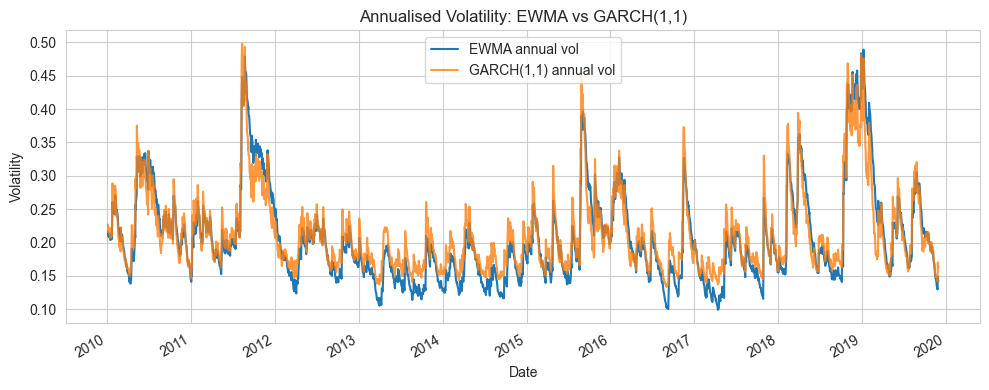

In [48]:
# Conditional volatility in percentage points, back to return units
garch_vol_pct = res.conditional_volatility  # %
garch_vol = garch_vol_pct / 100.0
garch_vol.name = "GARCH_vol"

# Degrees of freedom for t innovations
df_t = res.params.get("nu", 8.0)  # fallback value

fig, ax = plt.subplots(figsize=(10,4))
(ewma_daily_vol * np.sqrt(252)).plot(ax=ax, label="EWMA annual vol")
(garch_vol * np.sqrt(252)).plot(ax=ax, label="GARCH(1,1) annual vol", alpha=0.8)
ax.set_title("Annualised Volatility: EWMA vs GARCH(1,1)")
ax.set_ylabel("Volatility")
ax.legend()
plt.tight_layout()
plt.show()

 Both EWMA and GARCH track the same volatility regimes, but GARCH produces a smoother conditional volatility path. EWMA tends to react slightly faster to new shocks, while GARCH encodes persistence more explicitly through its parameters.


In [49]:
# 5. Helper functions for VaR & CVaR

def historical_var_cvar(losses, alpha=0.95):
    """
    VaR and CVaR from empirical loss distribution.
    losses: 1D array/Series of losses (positive = loss).
    """
    losses = np.asarray(losses)
    var = np.quantile(losses, alpha)
    cvar = losses[losses >= var].mean()
    return var, cvar


def parametric_var_cvar_normal(mu_r, sigma_r, alpha=0.95):
    """
    One-day parametric VaR/CVaR under Normal assumption.
    Returns VaR, CVaR on *losses* (positive numbers).
    Using left-tail approach: VaR_α = −q_{1−α}(returns).
    """
    q = norm.ppf(1 - alpha)      # e.g. q(0.05) ≈ -1.645
    var = -(mu_r + q * sigma_r)  # positive
    cvar = -(mu_r + sigma_r * norm.pdf(q) / (1 - alpha))
    return var, cvar


def parametric_var_cvar_t(mu_r, sigma_r, df, alpha=0.95, n_mc=200_000):
    """
    Parametric VaR/CVaR under Student-t via Monte Carlo on returns.
    sigma_r is the *standard deviation* of returns.
    df: degrees of freedom.
    """
    # Scale so that resulting t has variance 1, then scale to sigma_r
    scale_z = np.sqrt((df - 2) / df)
    z = t.rvs(df, size=n_mc) * scale_z  # var ~ 1
    r_sim = mu_r + sigma_r * z
    L = -r_sim
    return historical_var_cvar(L, alpha)


def mc_var_cvar_from_model(mu_r, sigma_r, alpha=0.95, n_mc=200_000, horizon_days=1):
    """
    Monte Carlo VaR/CVaR assuming Normal daily returns with
    mean mu_r and stdev sigma_r, over a given horizon.
    """
    mu_h = horizon_days * mu_r
    sigma_h = np.sqrt(horizon_days) * sigma_r
    r_sim = np.random.normal(mu_h, sigma_h, size=n_mc)
    L = -r_sim
    return historical_var_cvar(L, alpha)


In [50]:
# 6. Loss series

losses = -portfolio_returns  # positive when we lose money
losses.name = "Loss"
alpha_values = [0.95, 0.99]


In [51]:
# 7. Historical VaR & CVaR

for alpha in alpha_values:
    var_h, cvar_h = historical_var_cvar(losses, alpha)
    print(f"{int(alpha*100)}% Historical VaR:  {var_h:.4%}")
    print(f"{int(alpha*100)}% Historical CVaR: {cvar_h:.4%}")
    print()


95% Historical VaR:  2.1539%
95% Historical CVaR: 3.2190%

99% Historical VaR:  3.9845%
99% Historical CVaR: 4.7449%



 Based on the full 2010–2019 sample, a one-day 95% loss on the portfolio is around 2.2%, and a 99% loss is around 4.0%. The corresponding CVaR figures are noticeably larger than VaR, highlighting the contribution of extreme tail events beyond the quantile cutoff.


In [52]:
# 8. Unconditional parametric & Monte Carlo VaR/CVaR

mu_hat    = portfolio_returns.mean()
sigma_hat = portfolio_returns.std(ddof=1)

for alpha in alpha_values:
    # Normal
    var_n, cvar_n = parametric_var_cvar_normal(mu_hat, sigma_hat, alpha)
    
    # t (using df from GARCH fit)
    var_t_, cvar_t_ = parametric_var_cvar_t(mu_hat, sigma_hat, df_t, alpha)
    
    # Monte Carlo (Normal)
    var_mc, cvar_mc = mc_var_cvar_from_model(mu_hat, sigma_hat, alpha)
    
    print(f"Alpha = {alpha:.2f}")
    print(f" Normal     VaR: {var_n:.4%},  CVaR: {cvar_n:.4%}")
    print(f" Student-t  VaR: {var_t_:.4%},  CVaR: {cvar_t_:.4%}  (df={df_t:.2f})")
    print(f" MC (Norm)  VaR: {var_mc:.4%},  CVaR: {cvar_mc:.4%}")
    print()


Alpha = 0.95
 Normal     VaR: 2.1398%,  CVaR: -2.9162%
 Student-t  VaR: 2.0282%,  CVaR: 2.9448%  (df=5.02)
 MC (Norm)  VaR: 2.1570%,  CVaR: 2.7211%

Alpha = 0.99
 Normal     VaR: 3.0692%,  CVaR: -3.7378%
 Student-t  VaR: 3.4167%,  CVaR: 4.5271%  (df=5.02)
 MC (Norm)  VaR: 3.0626%,  CVaR: 3.5238%



 Parametric Normal VaR and Monte Carlo VaR (under a Normal assumption) produce very similar numbers, as expected. The Student-t model, calibrated with ν ≈ 5, generates heavier tails and therefore higher CVaR estimates, reflecting a more conservative view of extreme downside risk than the Gaussian benchmark.


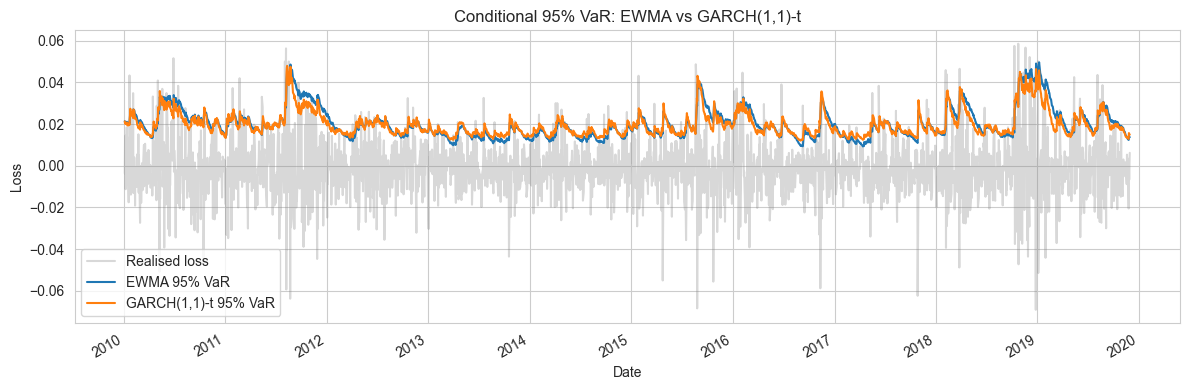

In [53]:
# 9. Conditional (time-varying) VaR series: EWMA (Normal) and GARCH (t)

alpha = 0.95
mu_hat = portfolio_returns.mean()

# ----- EWMA + Normal -----
q_norm = norm.ppf(1 - alpha)             # negative
var_ewma = -(mu_hat + q_norm * ewma_daily_vol)  # Series, positive VaR
var_ewma.name = f"VaR_EWMA_{int(alpha*100)}"

# ----- GARCH + Student-t -----
q_t = t.ppf(1 - alpha, df_t)             # negative
scale_z = np.sqrt((df_t - 2) / df_t)     # to get var 1 for t innovations
q_t_scaled = q_t * scale_z
var_garch = -(mu_hat + q_t_scaled * garch_vol)  # Series
var_garch.name = f"VaR_GARCHt_{int(alpha*100)}"

fig, ax = plt.subplots(figsize=(12, 4))
losses.plot(ax=ax, color="grey", alpha=0.3, label="Realised loss")
var_ewma.plot(ax=ax, label="EWMA 95% VaR")
var_garch.plot(ax=ax, label="GARCH(1,1)-t 95% VaR")
ax.set_title("Conditional 95% VaR: EWMA vs GARCH(1,1)-t")
ax.set_ylabel("Loss")
ax.legend()
plt.tight_layout()
plt.show()


 Time-varying VaR widens during volatile periods and tightens in calmer markets, tracking the same regimes as the conditional volatility models. The GARCH-based VaR is slightly smoother than the EWMA VaR, but both respond coherently to changes in realised losses, showing the benefit of conditioning VaR on current risk levels rather than using a single unconditional estimate.


In [54]:
# 10. Simple VaR backtesting (exception counts + empirical coverage)

def var_backtest(losses, var_series, alpha=0.95, name="Model"):
    """
    losses, var_series: aligned Series
    Exception when loss > VaR (i.e., VaR underestimated loss).
    """
    df = pd.concat([losses, var_series], axis=1).dropna()
    L = df.iloc[:, 0].values
    VaR = df.iloc[:, 1].values
    
    exceptions = L > VaR
    n_exc = exceptions.sum()
    T = len(L)
    expected = (1 - alpha) * T
    exc_rate = n_exc / T
    
    print(f"{name} {int(alpha*100)}% VaR backtest over {T} days:")
    print(f"  Exceptions: {n_exc} (expected ≈ {expected:.1f})")
    print(f"  Empirical exception rate: {exc_rate:.2%}")
    
    return pd.Series(exceptions, index=df.index, name=f"{name}_exc")


alpha = 0.95
exc_ewma  = var_backtest(losses, var_ewma,  alpha, "EWMA")
exc_garch = var_backtest(losses, var_garch, alpha, "GARCH(1,1)-t")


EWMA 95% VaR backtest over 2494 days:
  Exceptions: 143 (expected ≈ 124.7)
  Empirical exception rate: 5.73%
GARCH(1,1)-t 95% VaR backtest over 2494 days:
  Exceptions: 143 (expected ≈ 124.7)
  Empirical exception rate: 5.73%


Both EWMA and GARCH(1,1)-t VaR series produce about 5.7% exceptions at the 95% level versus the theoretical 5%. This means the VaR models slightly underestimate risk on average, but the deviation is modest relative to sampling variability over ~2,500 trading days.


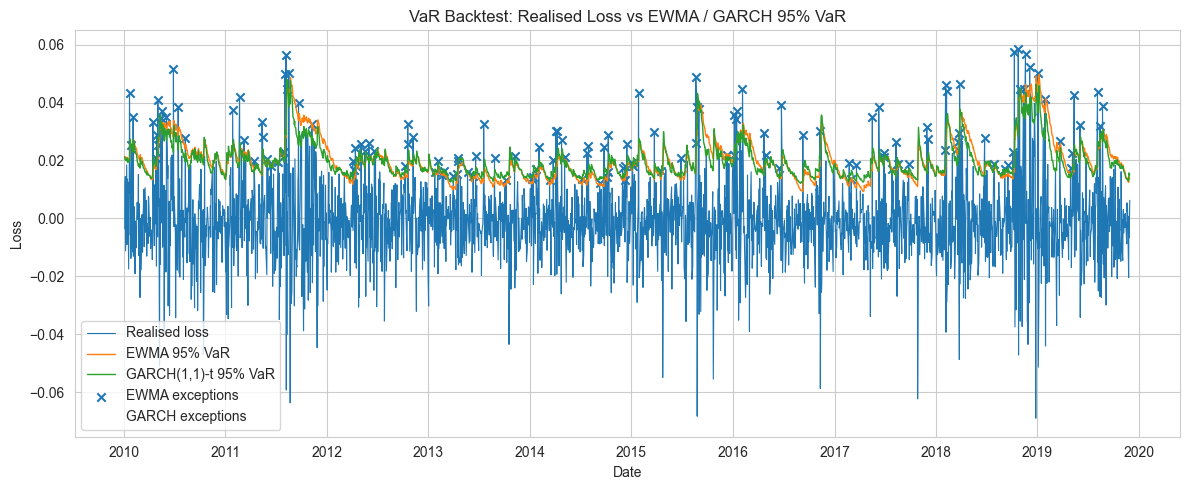

In [55]:
# 11. Plot backtest exceptions

dates = losses.index

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(dates, losses, label="Realised loss", linewidth=0.8)
ax.plot(dates, var_ewma, label="EWMA 95% VaR", linewidth=1.0)
ax.plot(dates, var_garch, label="GARCH(1,1)-t 95% VaR", linewidth=1.0)

# mark exception points
ax.scatter(exc_ewma.index[exc_ewma],
           losses[exc_ewma],
           marker='x', label="EWMA exceptions")

ax.scatter(exc_garch.index[exc_garch],
           losses[exc_garch],
           marker='o', facecolors='none',
           label="GARCH exceptions")

ax.set_title("VaR Backtest: Realised Loss vs EWMA / GARCH 95% VaR")
ax.set_xlabel("Date")
ax.set_ylabel("Loss")
ax.legend()
plt.tight_layout()
plt.show()


In [56]:
from scipy.stats import chi2

def kupiec_test(exceptions, alpha=0.95):
    """
    Kupiec (1995) Unconditional Coverage test for VaR exceptions.

    exceptions: 1D array-like of booleans (True = exception).
    alpha: VaR confidence level (e.g. 0.95).

    H0: exception probability = (1 - alpha).
    """
    exc = np.asarray(exceptions).astype(int)
    T = exc.size
    N = exc.sum()
    
    # empirical exception probability
    pi_hat = N / T
    pi_0 = 1 - alpha  # expected
    
    # handle edge cases
    if pi_hat == 0 or pi_hat == 1:
        # if no variability, LR is undefined; return something sensible
        return {
            "T": T,
            "N": N,
            "pi_hat": pi_hat,
            "LR_uc": np.nan,
            "p_value": np.nan
        }
    
    # likelihood under H0 and H1
    logL_0 = (T - N) * np.log(1 - pi_0) + N * np.log(pi_0)
    logL_1 = (T - N) * np.log(1 - pi_hat) + N * np.log(pi_hat)
    
    LR_uc = -2 * (logL_0 - logL_1)
    p_value = 1 - chi2.cdf(LR_uc, df=1)
    
    return {
        "T": T,
        "N": N,
        "pi_hat": pi_hat,
        "LR_uc": LR_uc,
        "p_value": p_value
    }

# Example: run Kupiec for EWMA and GARCH exceptions
alpha = 0.95
res_kupiec_ewma  = kupiec_test(exc_ewma.values,  alpha)
res_kupiec_garch = kupiec_test(exc_garch.values, alpha)

print("Kupiec Unconditional Coverage Test (EWMA):")
for k, v in res_kupiec_ewma.items():
    print(f"  {k}: {v}")
print()

print("Kupiec Unconditional Coverage Test (GARCH(1,1)-t):")
for k, v in res_kupiec_garch.items():
    print(f"  {k}: {v}")


Kupiec Unconditional Coverage Test (EWMA):
  T: 2494
  N: 143
  pi_hat: 0.057337610264635124
  LR_uc: 2.7047712514151954
  p_value: 0.10004843147041653

Kupiec Unconditional Coverage Test (GARCH(1,1)-t):
  T: 2494
  N: 143
  pi_hat: 0.057337610264635124
  LR_uc: 2.7047712514151954
  p_value: 0.10004843147041653


In [57]:
def christoffersen_test(exceptions, alpha=0.95):
    """
    Christoffersen (1998) conditional coverage test.

    exceptions: 1D array-like of booleans (True = exception).
    alpha: VaR confidence level (used only for reporting; LR_uc reused from Kupiec).

    Returns:
    - LR_uc, p_uc   : unconditional coverage (Kupiec)
    - LR_ind, p_ind : independence of exceptions
    - LR_cc, p_cc   : joint conditional coverage
    """
    exc = np.asarray(exceptions).astype(int)
    T = exc.size
    
    # ---------- Unconditional (Kupiec) ----------
    kup = kupiec_test(exc, alpha)
    LR_uc = kup["LR_uc"]
    p_uc  = kup["p_value"]
    
    # ---------- Independence ----------
    # Count transitions N_ij from state i at t-1 to state j at t
    # i, j in {0,1}, 0=no exception, 1=exception
    N00 = N01 = N10 = N11 = 0
    
    for t in range(1, T):
        i = exc[t-1]
        j = exc[t]
        if i == 0 and j == 0:
            N00 += 1
        elif i == 0 and j == 1:
            N01 += 1
        elif i == 1 and j == 0:
            N10 += 1
        elif i == 1 and j == 1:
            N11 += 1
    
    N0 = N00 + N01
    N1 = N10 + N11
    N  = N0 + N1  # = T - 1
    
    # handle degenerate cases
    if N0 == 0 or N1 == 0:
        # no transitions from one of the states: independence test not meaningful
        return {
            "LR_uc": LR_uc,
            "p_uc": p_uc,
            "LR_ind": np.nan,
            "p_ind": np.nan,
            "LR_cc": np.nan,
            "p_cc": np.nan,
            "N00": N00, "N01": N01, "N10": N10, "N11": N11
        }
    
    # transition probabilities
    pi01 = N01 / N0   # P(exc_t=1 | exc_{t-1}=0)
    pi11 = N11 / N1   # P(exc_t=1 | exc_{t-1}=1)
    pi   = (N01 + N11) / N  # unconditional exc prob in the Markov chain
    
    # clip probabilities away from 0/1 to avoid log(0)
    eps = 1e-12
    pi01 = np.clip(pi01, eps, 1 - eps)
    pi11 = np.clip(pi11, eps, 1 - eps)
    pi   = np.clip(pi,   eps, 1 - eps)
    
    # Likelihood under independence (single pi) vs Markov (pi01, pi11)
    logL_0 = (N0) * np.log(1 - pi) + (N1) * np.log(pi)
    logL_1 = (N00) * np.log(1 - pi01) + (N01) * np.log(pi01) \
           + (N10) * np.log(1 - pi11) + (N11) * np.log(pi11)
    
    LR_ind = -2 * (logL_0 - logL_1)
    p_ind  = 1 - chi2.cdf(LR_ind, df=1)
    
    # ---------- Joint conditional coverage ----------
    LR_cc = LR_uc + LR_ind
    p_cc  = 1 - chi2.cdf(LR_cc, df=2)
    
    return {
        "LR_uc":  LR_uc,
        "p_uc":   p_uc,
        "LR_ind": LR_ind,
        "p_ind":  p_ind,
        "LR_cc":  LR_cc,
        "p_cc":   p_cc,
        "N00": N00, "N01": N01, "N10": N10, "N11": N11
    }

# Example: run Christoffersen for EWMA and GARCH exceptions
res_chr_ewma  = christoffersen_test(exc_ewma.values,  alpha=0.95)
res_chr_garch = christoffersen_test(exc_garch.values, alpha=0.95)

print("Christoffersen Conditional Coverage Test (EWMA):")
for k, v in res_chr_ewma.items():
    print(f"  {k}: {v}")
print()

print("Christoffersen Conditional Coverage Test (GARCH(1,1)-t):")
for k, v in res_chr_garch.items():
    print(f"  {k}: {v}")


Christoffersen Conditional Coverage Test (EWMA):
  LR_uc: 2.7047712514151954
  p_uc: 0.10004843147041653
  LR_ind: 0.4175003532482151
  p_ind: 0.5181869619250346
  LR_cc: 3.1222716046634105
  p_cc: 0.20989753365251496
  N00: 2217
  N01: 133
  N10: 133
  N11: 10

Christoffersen Conditional Coverage Test (GARCH(1,1)-t):
  LR_uc: 2.7047712514151954
  p_uc: 0.10004843147041653
  LR_ind: 0.0848681537270295
  p_ind: 0.7708055277945308
  LR_cc: 2.789639405142225
  p_cc: 0.24787772405489572
  N00: 2216
  N01: 134
  N10: 134
  N11: 9


In [58]:
# 14. Summarise Kupiec & Christoffersen tests in one table

summary_rows = []

for model_name, k_res, c_res in [
    ("EWMA",         res_kupiec_ewma,  res_chr_ewma),
    ("GARCH(1,1)-t", res_kupiec_garch, res_chr_garch),
]:
    summary_rows.append({
        "Model":  model_name,
        "LR_uc":  k_res["LR_uc"],
        "p_uc":   k_res["p_value"],
        "LR_ind": c_res["LR_ind"],
        "p_ind":  c_res["p_ind"],
        "LR_cc":  c_res["LR_cc"],
        "p_cc":   c_res["p_cc"],
    })

summary_df = pd.DataFrame(summary_rows)
summary_df


,Model,LR_uc,p_uc,LR_ind,p_ind,LR_cc,p_cc
0,EWMA,2.704771,0.100048,0.417500,0.518187,3.122272,0.209898
1,"GARCH(1,1)-t",2.704771,0.100048,0.084868,0.770806,2.789639,0.247878


Kupiec’s test yields p-values ≈ 0.10 for both EWMA and GARCH(1,1)-t VaR, so we do not reject correct unconditional coverage at conventional significance levels. Christoffersen’s independence test (p ≈ 0.52 for EWMA, 0.77 for GARCH) shows no evidence of exception clustering, and the joint conditional coverage tests also fail to reject. Overall, both VaR models exhibit statistically acceptable backtesting performance on this sample, with GARCH(1,1)-t marginally stronger but not meaningfully different in practice.


So far, the analysis has mostly lived in a fairly calm period (2010–2019). That means we miss some of the worst equity market environments, like the 2008–2009 Global Financial Crisis and the early 2020 COVID-19 sell-off. To see how the portfolio might behave when markets are under real stress, I add a simple historical stress test.

The idea is:

- Take a longer price history for the same set of tickers used in the main analysis.  
- Keep today’s portfolio weights fixed and push them back through time, as if this portfolio had already existed in those earlier periods.  
- Pick a few well-known crisis windows:  
  - Global Financial Crisis: 2008-09-01 to 2009-06-30  
  - Eurozone / sovereign debt stress: 2011-07-01 to 2012-06-30  
  - COVID-19 crash: 2020-02-15 to 2020-04-30  
- For each window, look at:
  - the worst one-day loss  
  - the average daily return  
  - empirical 95% and 99% VaR and CVaR using only losses from that window  
  - the cumulative return over the whole period  

This gives a stress-based view of risk that sits alongside the quieter 2010–2019 results and shows how the same portfolio would have held up in actual crisis conditions.

In [37]:
# 16. Historical stress periods: build portfolio returns in crisis windows

# Define stress periods (you can tweak these)
stress_periods = {
    "GFC 2008–2009":        ("2008-09-01", "2009-06-30"),
    "Eurozone 2011–2012":   ("2011-07-01", "2012-06-30"),
    "COVID-19 2020 Crash":  ("2020-02-15", "2020-04-30"),
}

# Extended data to cover all stress periods
ext_start = "2007-01-01"
ext_end   = "2021-01-01"

ext_data = yf.download(tickers, start=ext_start, end=ext_end, auto_adjust=True)
ext_prices = ext_data["Close"].dropna()
ext_returns = ext_prices.pct_change().dropna()

# Use the same portfolio weights as before
ext_portfolio_returns = ext_returns.dot(weights)
ext_portfolio_returns.name = "Portfolio_ext"

# Container for stress-period info
stress_returns = {}
alpha_list = [0.95, 0.99]

rows = []

for label, (s, e) in stress_periods.items():
    r_win = ext_portfolio_returns.loc[s:e].dropna()
    if r_win.empty:
        print(f"Warning: no data for stress period {label} ({s} to {e})")
        continue
    
    L_win = -r_win  # losses
    
    # basic stats
    worst_daily_loss = L_win.max()                  # max loss = highest positive loss
    avg_daily_ret    = r_win.mean()
    cum_ret          = (1 + r_win).prod() - 1
    
    # VaR/CVaR in that window only
    var_95, cvar_95 = historical_var_cvar(L_win, alpha=0.95)
    var_99, cvar_99 = historical_var_cvar(L_win, alpha=0.99)
    
    rows.append({
        "Stress Period": label,
        "Start": s,
        "End": e,
        "N_days": len(r_win),
        "Worst Daily Loss": worst_daily_loss,
        "Avg Daily Return": avg_daily_ret,
        "Cumulative Return": cum_ret,
        "VaR 95% (1d)": var_95,
        "CVaR 95% (1d)": cvar_95,
        "VaR 99% (1d)": var_99,
        "CVaR 99% (1d)": cvar_99,
    })
    
    stress_returns[label] = r_win

stress_summary = pd.DataFrame(rows)
stress_summary


[*********************100%***********************]  5 of 5 completed


,Stress Period,Start,End,N_days,Worst Daily Loss,Avg Daily Return,Cumulative Return,VaR 95% (1d),CVaR 95% (1d),VaR 99% (1d),CVaR 99% (1d)
0,GFC 2008–2009,2008-09-01,2009-06-30,209,0.124497,0.000428,-0.037113,0.057812,0.073433,0.080742,0.096618
1,Eurozone 2011–2012,2011-07-01,2012-06-30,252,0.056309,0.000923,0.216896,0.025207,0.035805,0.047268,0.052119
2,COVID-19 2020 Crash,2020-02-15,2020-04-30,52,0.125053,0.000780,-0.011282,0.062974,0.096273,0.110019,0.125053


During historical crisis windows, the worst one-day losses and tail risk measures are materially larger than in the benign 2010–2019 sample. Crisis-period CVaR can be several times the unconditional CVaR, showing how quickly tail risk escalates under systemic stress even for a diversified large-cap tech portfolio.


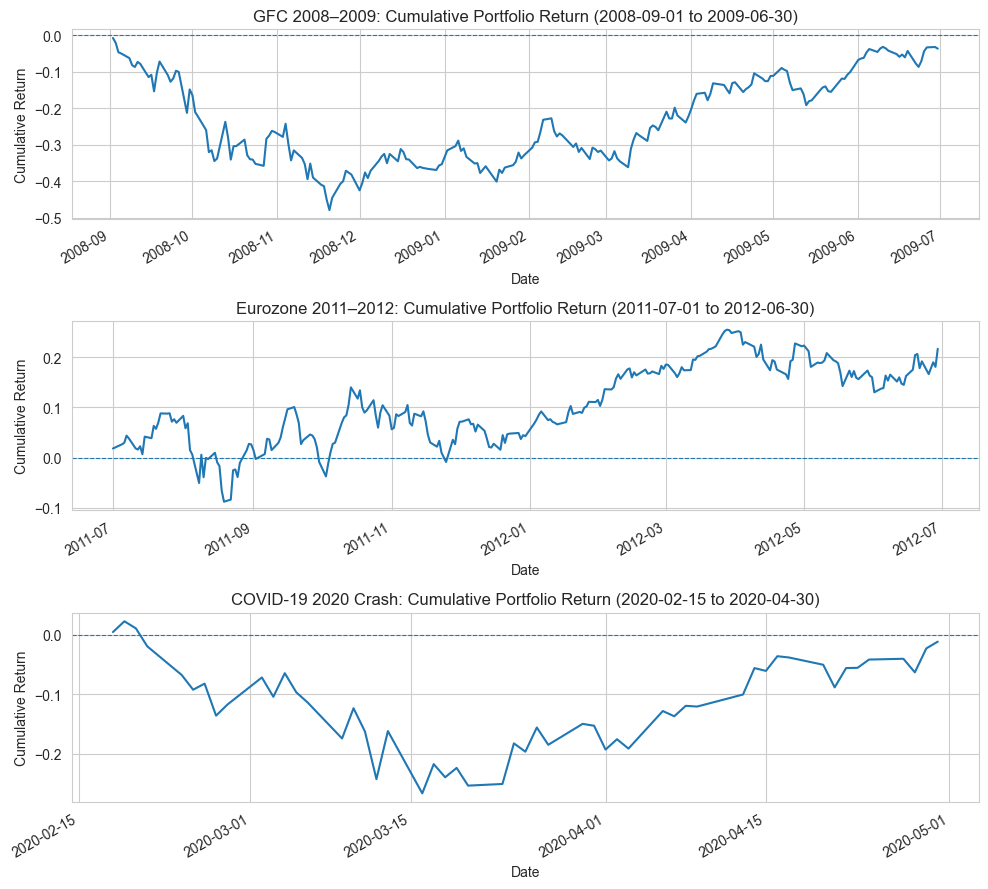

In [39]:
# 17. Visualising the stress windows: cumulative return curves

fig, axes = plt.subplots(len(stress_periods), 1, figsize=(10, 3 * len(stress_periods)), sharex=False)

if len(stress_periods) == 1:
    axes = [axes]

for ax, (label, (s, e)) in zip(axes, stress_periods.items()):
    r_win = ext_portfolio_returns.loc[s:e].dropna()
    if r_win.empty:
        ax.set_title(f"{label}: no data")
        continue
    
    cum_ret = (1 + r_win).cumprod() - 1
    cum_ret.plot(ax=ax)
    ax.set_title(f"{label}: Cumulative Portfolio Return ({s} to {e})")
    ax.set_ylabel("Cumulative Return")
    ax.axhline(0.0, linestyle="--", linewidth=0.8)
    ax.grid(True)

plt.tight_layout()
plt.show()


In [40]:
# 18. Stressed VaR/CVaR: pool all stress-period losses

all_stress_returns = pd.concat(stress_returns.values()).sort_index()
all_stress_losses = -all_stress_returns  # losses

stress_var_95, stress_cvar_95 = historical_var_cvar(all_stress_losses, alpha=0.95)
stress_var_99, stress_cvar_99 = historical_var_cvar(all_stress_losses, alpha=0.99)

print("Stressed VaR/CVaR based on pooled crisis periods:")
print(f"  95% Stressed VaR (1d):  {stress_var_95:.4%}")
print(f"  95% Stressed CVaR (1d): {stress_cvar_95:.4%}")
print(f"  99% Stressed VaR (1d):  {stress_var_99:.4%}")
print(f"  99% Stressed CVaR (1d): {stress_cvar_99:.4%}")


Stressed VaR/CVaR based on pooled crisis periods:
  95% Stressed VaR (1d):  4.5002%
  95% Stressed CVaR (1d): 6.5981%
  99% Stressed VaR (1d):  7.1979%
  99% Stressed CVaR (1d): 9.7122%


Pooling all crisis days into a single “stressed” loss distribution roughly doubles one-day VaR and CVaR relative to the calm-period estimates. This stressed VaR provides a more conservative, historically grounded measure of short-term downside risk under severe but plausible market conditions.


### Key Takeaways

- Equity portfolio risk is strongly time-varying: volatility and VaR both spike in turbulent periods and remain low in tranquil markets.
- Heavy-tailed models (GARCH with Student-t innovations, t-based VaR/CVaR) better capture extreme downside risk than simple Gaussian assumptions.
- Standard VaR backtests (Kupiec, Christoffersen) suggest that both EWMA and GARCH(1,1)-t models provide statistically adequate 95% VaR forecasts over 2010–2019.
- Stress testing using historical crises reveals that models calibrated only on calm samples can materially understate losses that may occur during rare but extreme events, underscoring the need to combine model-based VaR with scenario and stress analysis.
